In [1]:
#Import python libraries (using Python 3.8)


import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import urllib.request
import zipfile
import networkx as nx
import osmnx as ox
import geopandas as gpd
import folium
import requests, json
from descartes import PolygonPatch
from shapely.geometry import Point, LineString, Polygon
from shapely.ops import cascaded_union
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from bs4 import BeautifulSoup
plt.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
warnings.simplefilter('ignore')


In [14]:
#Read in the hospitals dataset. This is also freely available here https://www.nhs.uk/about-us/nhs-website-datasets/
#-------------------------------------------------------------------------------------------------------------------

hospital = pd.read_csv('/Users/paul.carroll/Documents/Data/Hospital.csv', sep = ',')
hospital.head(2)

,OrganisationID,OrganisationCode,OrganisationType,SubType,Sector,OrganisationStatus,IsPimsManaged,OrganisationName,Address1,Address2,...,County,Postcode,Latitude,Longitude,ParentODSCode,ParentName,Phone,Email,Website,"Fax,,,"
0,17970,NDA07,Hospital,Hospital,Independent Sector,Visible,True,Walton Community Hospital - Virgin Care Servic...,NaN,Rodney Road,...,Surrey,KT12 3LD,51.379997,-0.406042,NDA,Virgin Care Services Ltd,01932 414205,NaN,NaN,"01932 253674,,,"
1,17981,NDA18,Hospital,Hospital,Independent Sector,Visible,True,Woking Community Hospital (Virgin Care),NaN,Heathside Road,...,Surrey,GU22 7HS,51.315132,-0.556289,NDA,Virgin Care Services Ltd,01483 715911,NaN,NaN,",,,"


In [4]:
#Some preparatory eda to organise and select the columns for the folium map
#--------------------------------------------------------------------------

hospital = hospital[(hospital['ParentName'].str.contains ('Lincolnshire'))].reset_index(drop = True)
hospital['Address'] = hospital[['Address2', 'Address3', 'County',]].astype(str).agg(', '.join, axis=1)
hospital['Address'] = hospital['Address'].str.title() + ', ' + hospital['Postcode']
hospital['Address'] = hospital['Address'].str.replace('Nan', '').str.replace(' ,', ' ')
hospital['Name'] = hospital['OrganisationName'].str.title()
hospital = hospital[['OrganisationCode', 'Name', 'Address', 'Postcode', 'Phone','ParentName','Latitude','Longitude']]


In [5]:
#Selecting the 4 24 hour A&E departments in Lincolnshire
#-------------------------------------------------------

hospital1 = hospital[hospital['Name'].str.contains('Pilgrim|Lincoln County|Diana, Princess|Scunthorpe')]

In [6]:
# Map visulation of Lincolnshire 24 hour A&E Departments
#-------------------------------------------------------

frame = folium.Figure(width=500, height=500)
folium_fig = folium.Map(
    location=[53.2, -0.3],
    tiles="cartodbpositron",
    zoom_start=8).add_to(frame)
for code, name, address, number, lat, lon in zip(hospital1['OrganisationCode'],
hospital1['Name'],
hospital1['Address'],
hospital1['Phone'],
hospital1['Latitude'],
hospital1['Longitude']):
    folium.Marker(
        [lat, lon],
        popup = folium.Popup('<b>' + 'Name: ' + '</b>'  + str(name) + '<br>'
        '<b>' + 'OrganisationCode: ' + '</b>' + str(code) + '<br>'
        '<b>' + 'Address: ' + '</b>' + str(address) + '<br>'
        '<b>' + 'Telephone Number: ' + '</b>' + str(number) + '<br>',
        max_width=len(address)*20),
        icon=folium.Icon(color="green", prefix='fa', icon="fa-medkit"),
        ).add_to(folium_fig)

folium_fig 

In [ ]:
# Enter your Google CP api key here 
#------------------------

api_key = <your_api_key>


In [8]:
# Search code, that when run brings up an input box
# Then run this cell
# Then type in your search 
# The output will return the name, latitude and longitude
# My search was 'Urgent Care Centre Lincolnshire', to see what next level care there may be after A & E. 


key = api_key

url = "https://maps.googleapis.com/maps/api/place/textsearch/json?"

query = input('Search query:')
  
r = requests.get(url + 'query=' + query +
                        '&key=' + key)

x = r.json()
  
y = x['results']
  
for i in range(len(y)):
    print(y[i]['name'],y[i]['geometry']['location']['lat'], y[i]['geometry']['location']['lng'])

Lincoln Urgent Treatment Centre 53.2339104 -0.5196066
Skegness Urgent Treatment Centre 53.1451456 0.3321511
Urgent Care Centre 53.06742999999999 -0.8067749
Grantham and District Hospital: Accident and Emergency Department 52.9201216 -0.6420511
Lincoln County Hospital Accident and Emergency 53.2339139 -0.5188239
Biuro Pomocy 53.2240921 -0.5423932
Skegness and District General Hospital 53.1450348 0.3325575000000001
Grantham and District Hospital 52.9210011 -0.6406482
Johnson Community Hospital 52.8018247 -0.1502238
County Hospital Louth 53.3702224 -0.0084531
Urgent Treatment Centre - Goole Hospital 53.7157176 -0.8741329999999999
Stamford and Rutland Hospital 52.6552399 -0.4687506
John Coupland Hospital 53.4118799 -0.7847
Corby Urgent Care Centre 52.4905986 -0.7124965999999999
Newark Hospital 53.0677058 -0.806459
Lincoln County Hospital 53.2335711 -0.519479
Sleaford Medical Group 52.9979591 -0.4063757
Peterborough City Care Centre 52.5743787 -0.2584554
North East Lincolnshire C C G 53.573

In [9]:
# This cell takes the output from the search above and populates a dataframe with Name, Latitude and Longitude 
#-------------------------------------------------------------------------------------------------------------

df = pd.DataFrame(y,columns=['name','geometry'])
df['Name'] = pd.DataFrame([x for x in df['name']])
df['location'] = pd.DataFrame([x for x in df['geometry']])['location']
df['Latitude'] = pd.DataFrame([x for x in df['location']])['lat']
df['Longitude'] = pd.DataFrame([x for x in df['location']])['lng']
df= df.drop(columns=['name','geometry','location'], axis=1)


In [15]:
# This is an example where the search results overlay the first folium map results 
#---------------------------------------------------------------------------------

frame = folium.Figure(width=500, height=500)
f_map = folium.Map([53.2, -0.3], zoom_start=8,  tiles="cartodbpositron").add_to(frame)
df.apply(lambda row: folium.CircleMarker(location=[row["Latitude"], row["Longitude"]], 
                                              radius=10, popup=row['Name'])
                                             .add_to(f_map), axis=1)

for code, name, address, number, lat, lon in zip(hospital1['OrganisationCode'],
hospital1['Name'],
hospital1['Address'],
hospital1['Phone'],
hospital1['Latitude'],
hospital1['Longitude']):
    folium.Marker(
        [lat, lon],
        popup = folium.Popup('<b>' + 'Name: ' + '</b>'  + str(name) + '<br>'
        '<b>' + 'OrganisationCode: ' + '</b>' + str(code) + '<br>'
        '<b>' + 'Address: ' + '</b>' + str(address) + '<br>'
        '<b>' + 'Telephone Number: ' + '</b>' + str(number) + '<br>',
        max_width=len(address)*20),
        icon=folium.Icon(color="green", prefix='fa', icon="fa-medkit"),
        ).add_to(f_map)

f_map

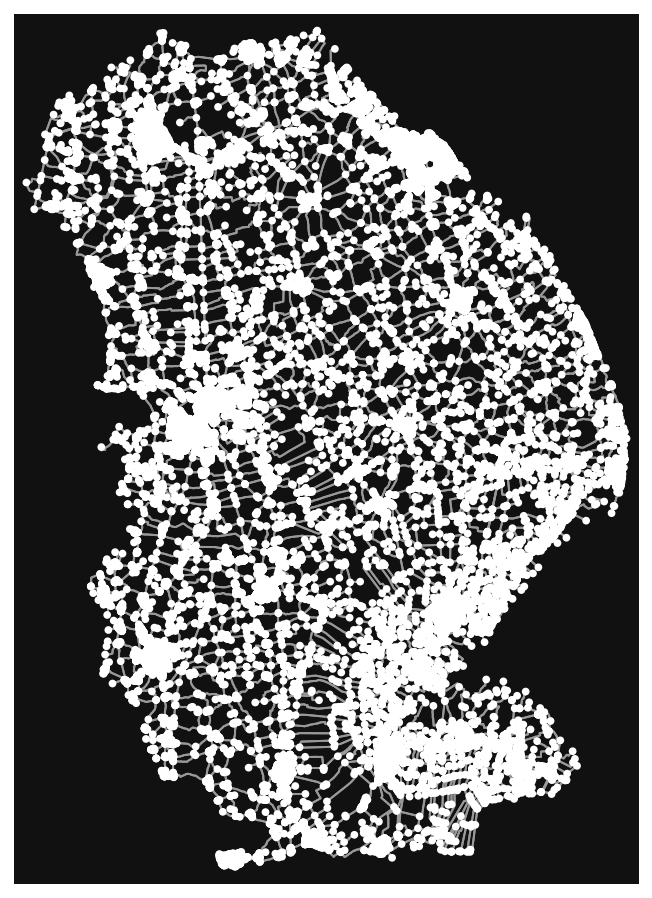

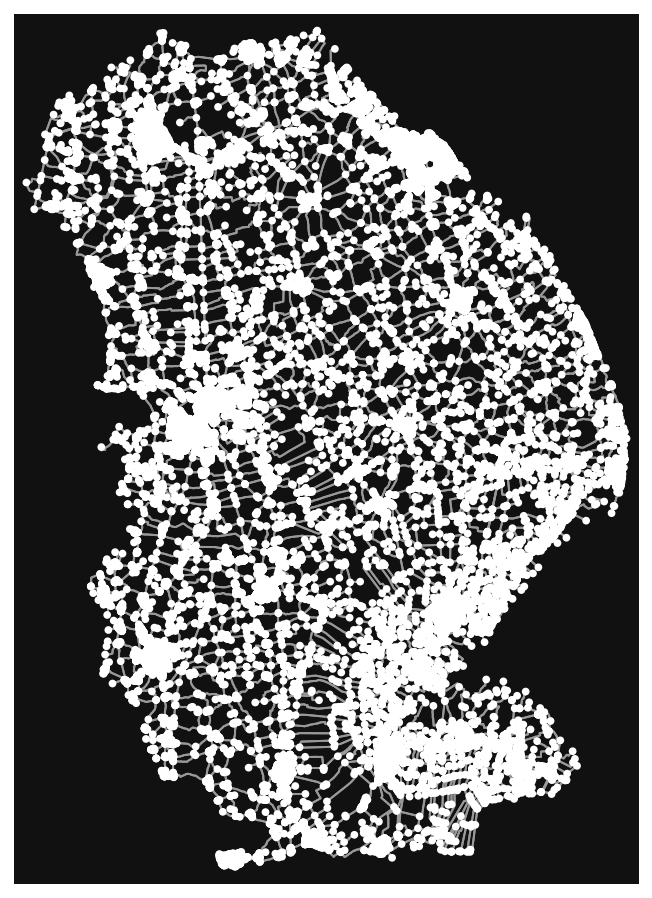

In [13]:
# Creates an OMSnx map of Lincolnshire, with the transport mode selected here as 'drive'.

place = "Lincolnshire, England"
G = ox.graph_from_place(place, network_type="drive")

ox.plot_graph(G);
fig, ax = ox.plot_graph(G);
#plt.tight_layout()
plt.show();

In [19]:
# combining the dataframes 
#-------------------------
hospital2 = hospital1[['Name','Latitude','Longitude']]
df_combined = hospital2.append(df)


In [20]:
# Map the dataframe coordinates onto the OSMnx nodes
#---------------------------------------------------

point_of_interest = ox.distance.nearest_nodes(G, X = df_combined['Longitude'], Y=df_combined['Latitude']) # X = longitude, Y = Latitude #------ nearest edge


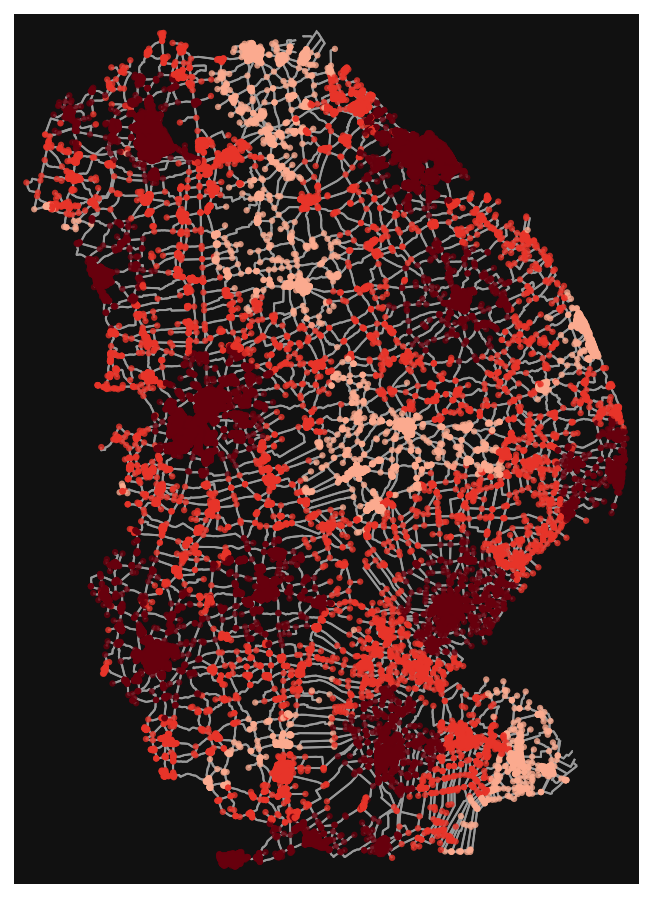

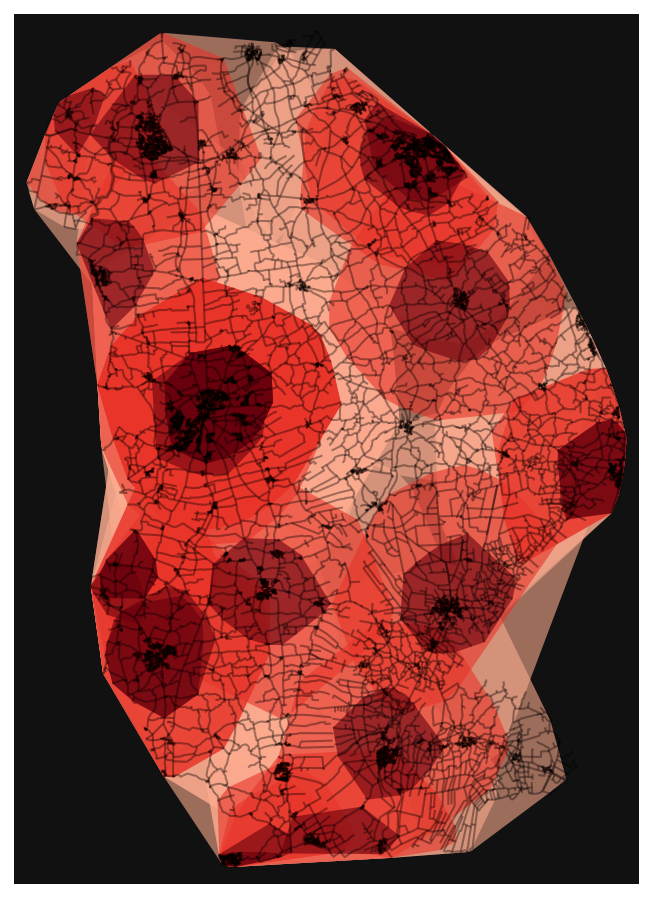

In [21]:
#Defining trip times of interest, walking speed, and adding and edge attribute 'time' to each edge in urban network graph
#------------------------------------------------------------------------------------------------------------------------
# Trip time in Mintues
trip_times = [10,20,30]

# transport speed in km/hour
travel_speed = 60

# add an edge attribute for time in minutes required to traverse each edge
meters_per_minute = travel_speed * 1000 / 60 #km per hour to m per minute
for u, v, k, data in G.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute

#---------------
# u,v,k refer to the unique indentifiers of an edge in a network graph. u and v are the two nodes the edege connects while the k, is the key attribute which differentiates between parallel edges. 
# data refers to edge attributes - these include length, osmid, oneway and others

# 1 - get one color for each isochrone
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap='Reds', start=0.3, return_hex=True)
# 2 - color the nodes according to isochrone then plot the street network
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    for points in point_of_interest:
        subgraph = nx.ego_graph(G, points, radius=trip_time, distance='time')
        for node in subgraph.nodes():
            node_colors[node] = color
nc = [node_colors[node] if node in node_colors else 'none' for node in G.nodes()]
ns = [10 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc, node_size=ns, node_alpha=0.8, node_zorder=2)

# make the isochrone polygons
#----------------------------
isochrone_polys = []
for trip_time in sorted(trip_times, reverse=True):
    isochrone_polys_sub = []
    for points in point_of_interest:
        subgraph = nx.ego_graph(G, points, radius=trip_time, distance='time')
        node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
        bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
        isochrone_polys_sub.append(bounding_poly)
    isochrone_polys.append(isochrone_polys_sub)

# plot the network then add isochrones as colored descartes polygon patches
#--------------------------------------------------------------------------
fig, ax = ox.plot_graph(G, show=False, close=False, edge_color='k', edge_alpha=0.2, node_color='none')
for polygon, fc in zip(isochrone_polys, iso_colors):
    for subpolygon in polygon:
        patch = PolygonPatch(subpolygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
        ax.add_patch(patch)
plt.show()

In [22]:
# Plot the travel time isochrones on top of the folium map

graph_map = ox.plot_graph_folium(G, f_map, color="#425563", opacity=0.5, weight=1)

style_geojson = [
{'shape_name': '30 min drive','shape_fillColor': '#003087'},
{'shape_name': '20 min drive', 'shape_fillColor': '#005EB8'},
{'shape_name': '10 min drive', 'shape_fillColor': '#41B6E6'}]
gdf_index = list(df_combined.index)
for polygon, style in zip(isochrone_polys, style_geojson):
     gdf = gpd.GeoDataFrame({"24Hour A&E": gdf_index}, geometry= polygon)
     polygon_json = list(gdf['geometry'])
     geojson = gpd.GeoSeries(cascaded_union(polygon_json)).to_json()
     fillColor = style['shape_fillColor']
     shape_name = style['shape_name']
     folium.GeoJson(geojson, name = shape_name, style_function = lambda x, fillColor = fillColor: {
            "fillColor": fillColor,
            "name":  shape_name,
            "weight": 1,
            "fillOpacity": 0.5,
            "color": "#000000"
            }).add_to(f_map)

folium.LayerControl().add_to(f_map)
f_map